# Прогнозирование уровня средней заработной платы в России

*Имеются [данные](http://sophist.hse.ru/exes/tables/WAG_M.htm) о заработной плате за каждый месяц с января 1993 по апрель 2019, которые необходимо проанализировать, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на три года вперёд от конца данных, учитывая два известных факта:*

1. __Теорема Вольда:__ любой стационарный ряд может быть описан моделью ***ARMA(p; q)*** с любой наперёд заданной точностью.
2. При помощи дифференцирования нестационарный ряд можно сделать стационарным.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    """Функция обратного преобразования временного ряда, к которому 
       применена трасформация Бокса-Кокса. Это необходимо для предсказания модели. 
    """
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


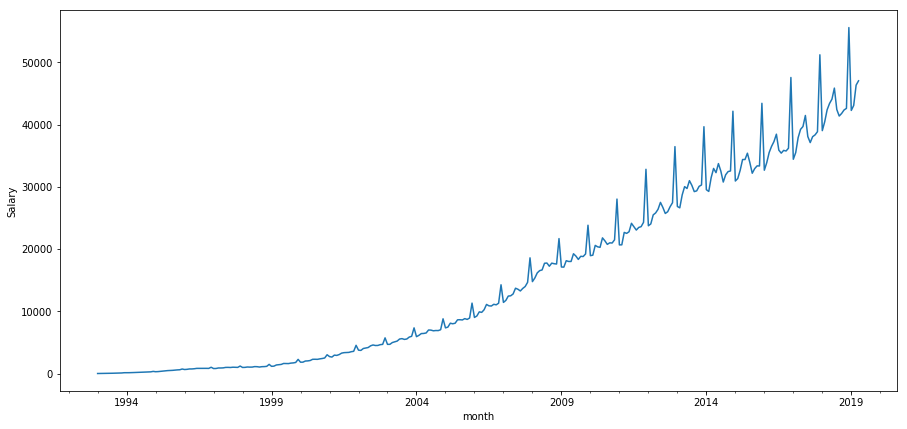

In [2]:
salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Формальная проверка стационарности и STL-декомпозиция ряда.

Критерий Дики-Фуллера: p=0.998567


<Figure size 1080x720 with 0 Axes>

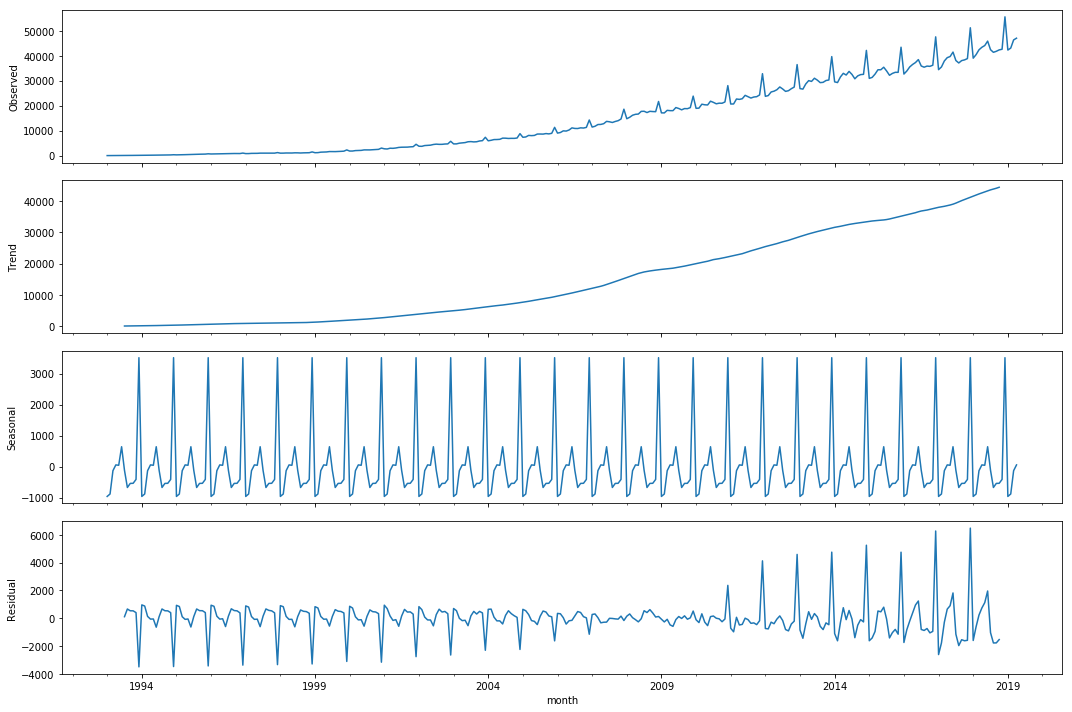

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1]);

_На графиках видно:_
* **ряд нестационарный с непостоянной дисперсией,**
* **наличие тренда,**
* **годовая сезонность.**

*Формально гипотезу о стационарности можно проверить с помощью критерия Дики-Фуллера:*
* $H_0$: ряд нестационарен
* $H_1$: ряд стационарен.

_Критерий Дики-Фуллера отвергает наличие стационарности._

# Стабилизация дисперсии

*Очень часто для стабилизации дисперсии используют параметрическое семейство функций - преобразования Бокса-Кокса, частным случаем которого является логарифмирование (при $\lambda = 0$). Применим преобразование Бокса-Кокса.*

Оптимальный параметр преобразования Бокса-Кокса: 0.284764
Критерий Дики-Фуллера: p=0.734177


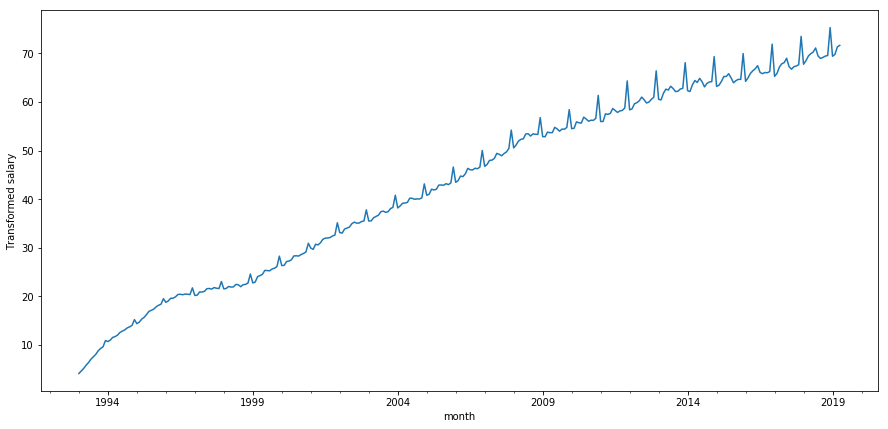

In [4]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary['salary_box'].plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box'])[1])

*Визуально видно, что преобразование Бокса-Кокса немного снизило дисперсию. Критерий Дики-Фуллера немного снизился.*

# Выбор порядка дифференцирования

*Применим сезонное дифференцирование. Выведем на продифференцированном ряде STL-декомпозицию и проверим стационарность:*

Критерий Дики-Фуллера: p=0.129633


<Figure size 1080x720 with 0 Axes>

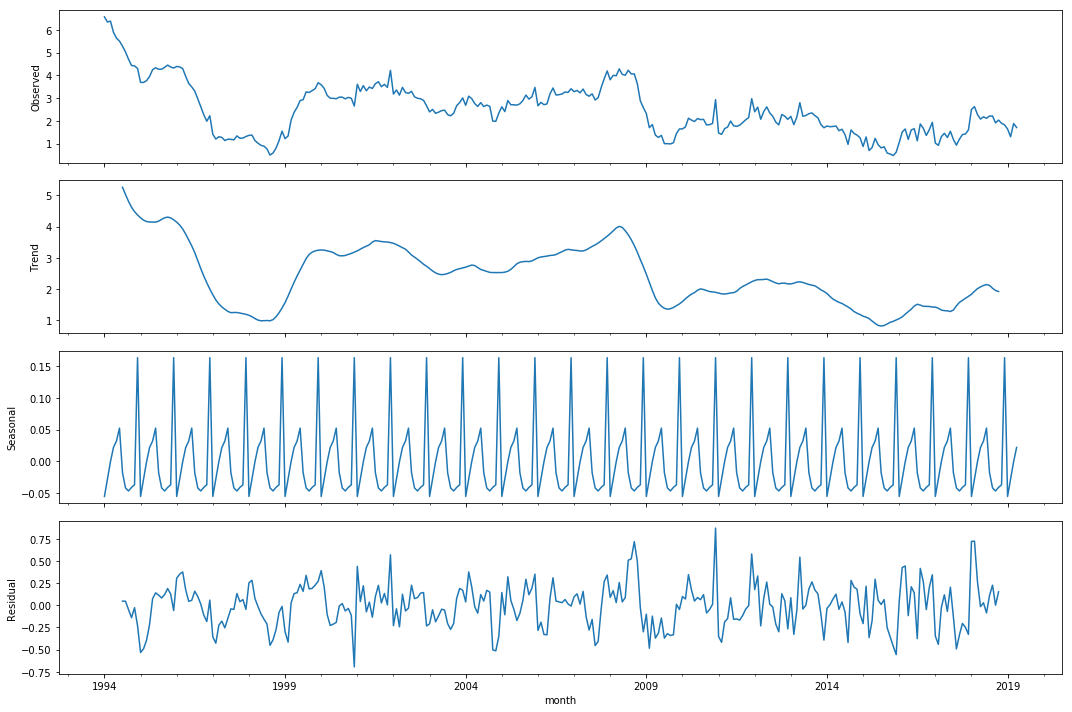

In [5]:
salary['salary_box_diff'] = salary['salary_box'] - salary['salary_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary['salary_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box_diff'][12:])[1])

*Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем добавить ещё обычное дифференцирование:*

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

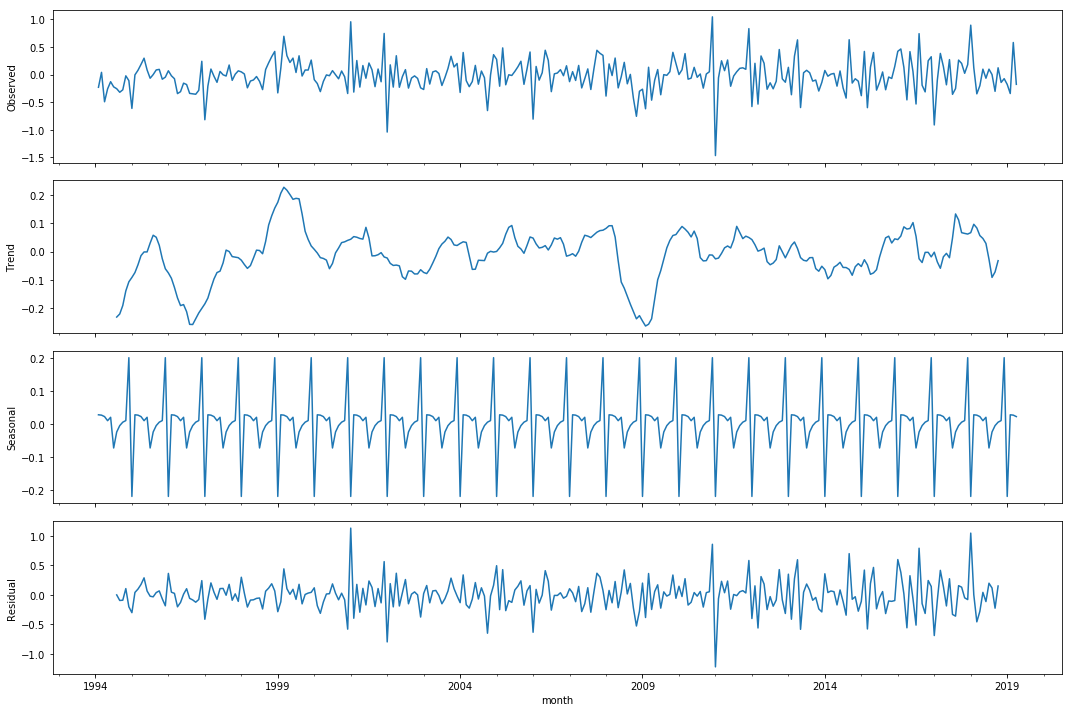

In [6]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

*Теперь нулевая гипотеза нестационарности отвергается и визуально приведенный ряд похож на стационарный.*

# Выбор начальных приближений для p, q, P, Q

* Начальное значение для параметра **Q * S** даёт номер последнего сезонного лага, при котором **автокорреляция** значима;
* параметр **q** задаётся номером последнего несезонного лага, при котором __автокорреляция__ значима;
* начальное приближение для параметра __P * S__ задаёт номер последнего сезонного лага, при котором **частичная автокорреляция** значима;
* **p** задаётся как номер последнего несезонного лага, при котором __частичная автокорреляция__ значима.

*Посмотрим на ACF и PACF полученного ряда:*

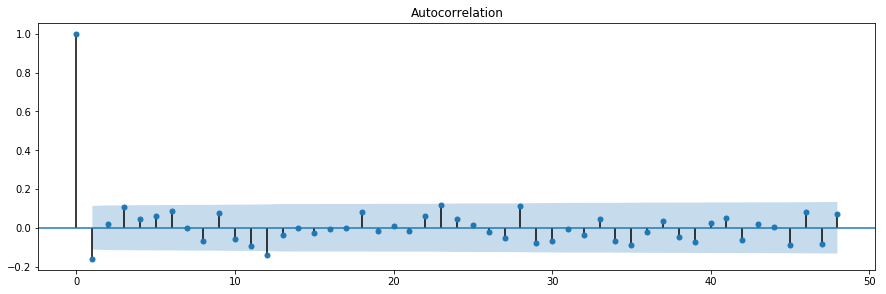

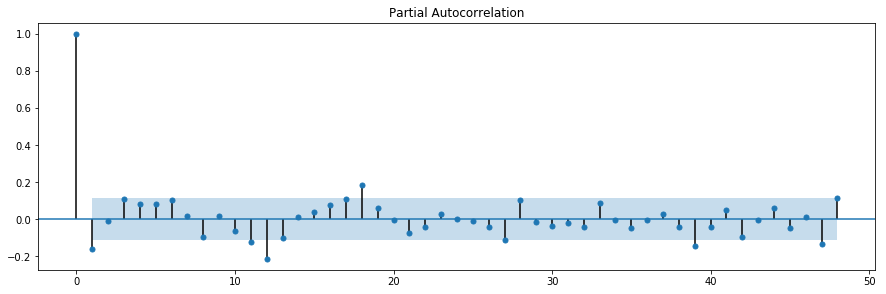

In [7]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

*Возьмем следующие начальные приближения: Q=1, q=3, P=1, p=3.*

In [8]:
# Диапазон значения для моделей
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Количество моделей-кандидатов для подбора параметров: ', len(parameters_list))

Количество моделей-кандидатов для подбора параметров:  64


*В качестве искомого критерия будем использовать информационный критерий Акаике. Оптимальной будет модель с наименьшим значением этого критерия.*

In [9]:
# Перебор моделей
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)


In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
42  (2, 3, 1, 0)  104.897624
41  (2, 3, 0, 1)  105.432715
54  (3, 3, 1, 0)  105.465042
43  (2, 3, 1, 1)  105.616590
53  (3, 3, 0, 1)  105.822046


*Лучшая модель:*

In [11]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  316
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                 -45.449
Date:                            Wed, 26 Jun 2019   AIC                            104.898
Time:                                    09:44:38   BIC                            130.894
Sample:                                01-01-1993   HQIC                           115.298
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7165      0.084     20.356      0.000       1.551       1.882
ar.L2         -0.8383      0.076   

*Её остатки:*

Критерий Стьюдента: p=0.579290
Критерий Дики-Фуллера: p=0.000000


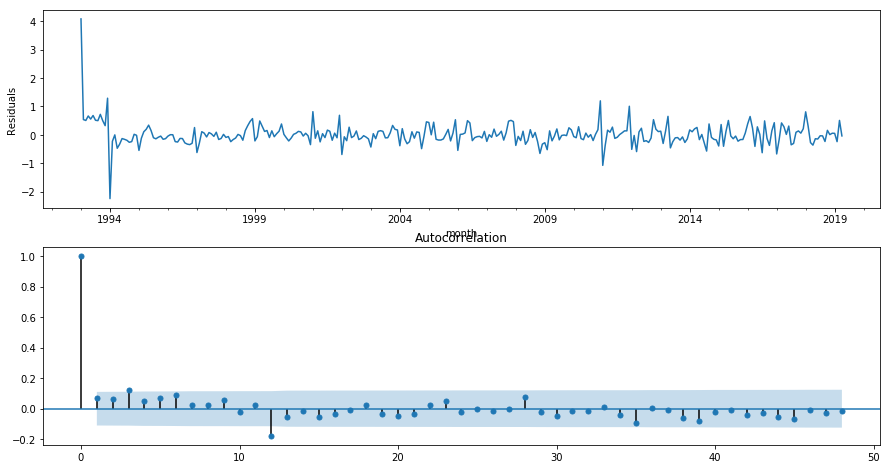

In [12]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

*Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:*

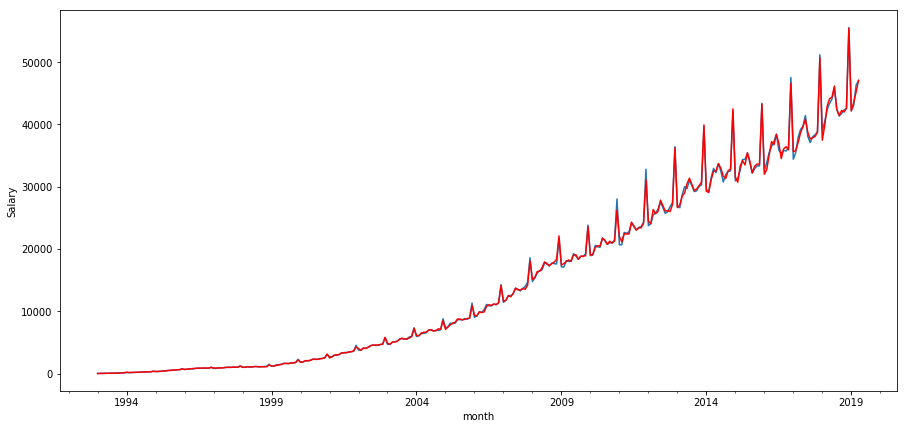

In [13]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model.plot(color='r')
plt.ylabel('Salary')
pylab.show()

# Прогноз

In [14]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1993-01-01 to 2019-04-01
Data columns (total 5 columns):
WAG_C_M             316 non-null float64
salary_box          316 non-null float64
salary_box_diff     304 non-null float64
salary_box_diff2    303 non-null float64
model               316 non-null float64
dtypes: float64(5)
memory usage: 14.8 KB


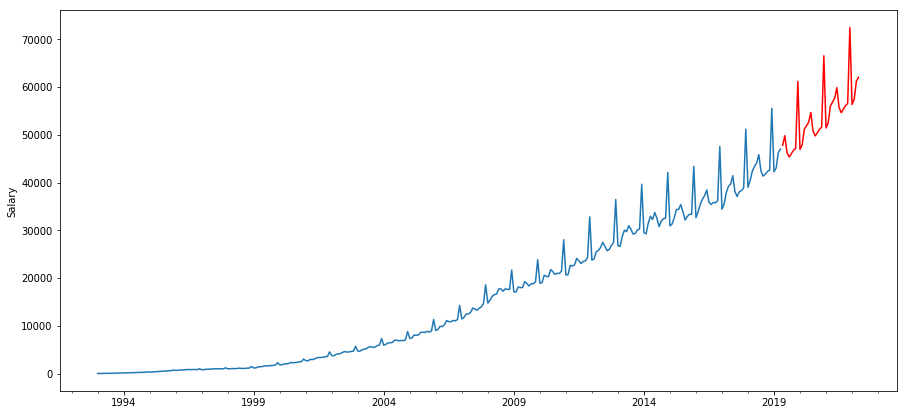

In [15]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2019-05-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=316, end=351), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()